In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

### Import Raw Port Visit Data

In [4]:
# Import the whole dataset
# For this we need to import the 5 xlsx files and concatenate them
# path = r'c:\\Users\\alezi\\OneDrive\\Escritorio\\Master_Thesis\\data_in'
# files = os.listdir(path)
# files_xlsx = [f for f in files if f[-4:] == 'xlsx']

# # Import the 3 xlsx files and concatenate them
# df = pd.DataFrame()
# for f in files_xlsx:
#     data = pd.read_excel(os.path.join(path, f))
#     df = pd.concat([df, data], ignore_index=True)

# #Export to parquet to avoid memory issues
# df.to_parquet(r'c:\\Users\\alezi\\OneDrive\\Escritorio\\Master_Thesis\\data_in\\total_port_visits.parquet')

In [25]:
# Import the parquet file
df1 = pd.read_parquet(r'c:\\Users\\alezi\\OneDrive\\Escritorio\\Master_Thesis\\data_in\\total_port_visits.parquet')

# Import the data previous to 2019
df2 = pd.read_parquet(r'c:\\Users\\alezi\\OneDrive\\Escritorio\\Master_Thesis\\data_in\\previous_data\\previous_data.parquet')


### Data Cleaning and Filtering

In [26]:
# Define a function to extract the flag of the second element of the vessel column
def extract_flag(vessel):
    if isinstance(vessel, str):
        return vessel.split(', ')[1].strip()
    else:
        return None
    
# Define a function to extract the id of the vessel first element of the vessel column
def extract_id(vessel):
    if isinstance(vessel, str):
        return vessel.split(', ')[0].strip()
    else:
        return None

# Define a function to extract the type of the vessel -2 element of the vessel column
def extract_type(vessel):
    if isinstance(vessel, str):
        return vessel.split(', ')[-2].strip()
    else:
        return None
    
# Define a function to extract the 7th element of the event_info column
def extract_event_info(event_info):
    if isinstance(event_info, str):
        return event_info.split(',')[6].strip()
    else:
        return None
    

In [27]:
# Apply the functions to the dataframe
df1['flag'] = df1['vessel'].apply(extract_flag)
df1['id_vessel'] = df1['vessel'].apply(extract_id)
df1['type_vessel'] = df1['vessel'].apply(extract_type)
df1['port_country'] = df1['event_info'].apply(extract_event_info)

In [32]:
# Concatenate the dataframes
df = pd.concat([df1, df2], ignore_index=True, axis=0)

#### Option 1 (Filter Based on 'event_info')

In [ ]:
# Keep the observations where the country1 or country2 is equal to 'GBR'
uk_port_visits = df[df['port_country'] == 'GBR']
# Set the 'start' and end date of the dataset as datetime
uk_port_visits['start'] = pd.to_datetime(uk_port_visits['start'])
uk_port_visits['end'] = pd.to_datetime(uk_port_visits['end'])

# Create 4 columns. One for the year_start, month_start, year_end and month_end
uk_port_visits['year_start'] = uk_port_visits['start'].dt.year
uk_port_visits['month_start'] = uk_port_visits['start'].dt.month
uk_port_visits['year_end'] = uk_port_visits['end'].dt.year
uk_port_visits['month_end'] = uk_port_visits['end'].dt.month

## We find some observation with very early start dates (2015, 2016, etc). We will remove them ##
# Keep the observations where the year_start is equal or greater than 2020
# uk_port_visits = uk_port_visits[uk_port_visits['year_start'] >= 2019]

In [34]:
uk_port_visits.flag.value_counts()

flag
GBR    421097
NOR     11240
IRL      3947
FRA      2655
BEL      1890
ESP       765
NLD       348
DNK       325
DEU        93
SWE        19
Name: count, dtype: int64

#### Option 2 (Geographical Filter)

##### Set the GeoDataFrame

In [6]:
# Load the UK map
uk = gpd.read_file(r"C:\Users\alezi\OneDrive\Escritorio\Master_Thesis\data_in\ne_10m_admin_0_countries\ne_10m_admin_0_countries.shp")
uk = uk[uk['ADM0_ISO'] == 'GBR']
uk = uk.to_crs(epsg=4326)

# Load the Afected Areas (12 miles)
uk_millas = gpd.read_file(r"C:\Users\alezi\Downloads\eez_12nm\eez_12nm.shp")
uk_millas.crs = "EPSG:4326"

# Load the EEZ of the UK
uk_eez = gpd.read_file(r"C:\Users\alezi\OneDrive\Escritorio\Master_Thesis\data_in\eez\eez.shp")
uk_eez.crs = "EPSG:4326"

# Set the geodataframe of GFW data
# gdf = gpd.GeoDataFrame(uk_port_visits, geometry=gpd.points_from_xy(uk_port_visits.lon, uk_port_visits.lat))
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
# Set the crs
gdf.crs = "EPSG:4326"

In [ ]:
## Geographical filter of the port visits ##
# Create a buffered area around the UK polygon (compute a buffer of 1)
buffer_distance = 1.0  # Adjust this distance as needed
buffered_eez_uk_polygon = uk_eez.buffer(buffer_distance)
# Drop a observation that is not in the EEZ_UK
# In this step I drop Ireland, Jersey, Guernsey, etc 
uk_gdf = gdf[gdf.within(buffered_eez_uk_polygon.unary_union)]
# Set the 'start' and end date of the dataset as datetime
uk_gdf['start'] = pd.to_datetime(uk_gdf['start'])
uk_gdf['end'] = pd.to_datetime(uk_gdf['end'])

# Create 4 columns. One for the year_start, month_start, year_end and month_end
uk_gdf['year_start'] = uk_gdf['start'].dt.year
uk_gdf['month_start'] = uk_gdf['start'].dt.month
uk_gdf['year_end'] = uk_gdf['end'].dt.year
uk_gdf['month_end'] = uk_gdf['end'].dt.month

# Keep the observations where the year_start is equal or greater than 2020
uk_gdf = uk_gdf[uk_gdf['year_start'] >= 2020]

In [39]:
# Create and export a csv file with the list of unique id_vessel and flag
unique_vessels = uk_port_visits[['id_vessel', 'flag']].drop_duplicates()
# unique_vessels = uk_gdf[['id_vessel', 'flag']].drop_duplicates()
unique_vessels.to_csv(r'c:\\Users\\alezi\\OneDrive\\Escritorio\\Master_Thesis\\data_out\\unique_id_vessels.csv', index=False)

In [42]:
unique_vessels.type_vessel.value_counts()

type_vessel
fishing    3078
carrier      17
other        10
Name: count, dtype: int64

In [11]:
uk_gdf.id_vessel.nunique()

3565

In [16]:
uk_port_visits.id_vessel.nunique()

2492

In [25]:
uk_gdf.id_vessel.nunique()

3099

In [46]:
uk_gdf.vessel[134]

'ee4409ed9-9530-1a82-524d-6cb8d2ed40f3, GBR, GLEN BAY II, fishing, 235082597'

In [17]:
uk_port_visits[uk_port_visits['flag'] != 'GBR'].id_vessel.nunique()

395

In [27]:
uk_gdf[uk_gdf['flag'] != 'GBR'].id_vessel.nunique()

1045

### Plots and Maps

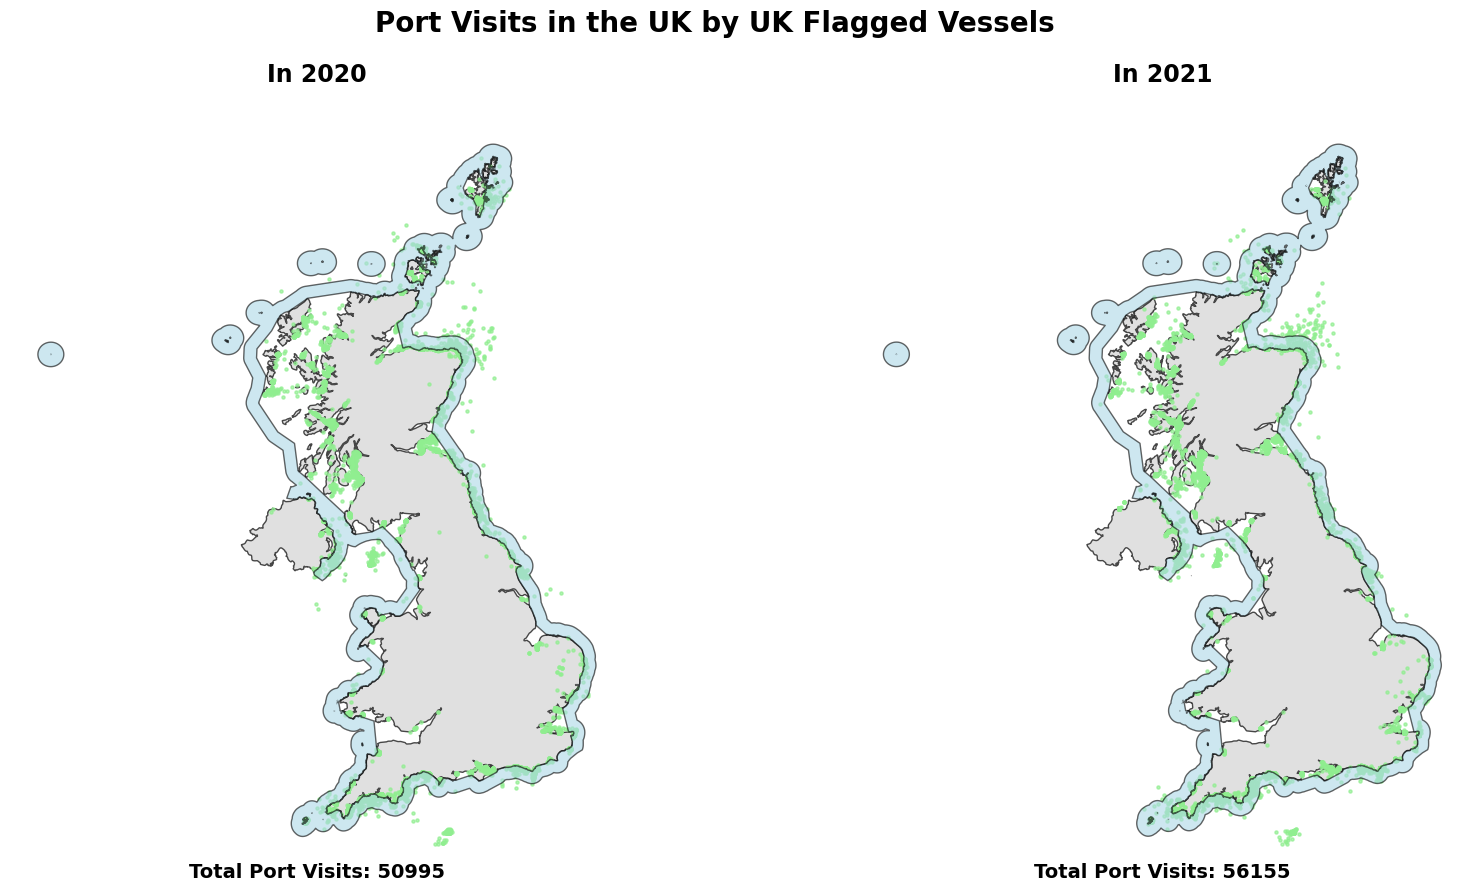

In [38]:
# Plot the UK map and the port_visits events
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, year in enumerate([2020, 2021]):
    uk.plot(ax=ax[i], color='lightgrey', edgecolor='black', alpha=0.7)
    gdf[(gdf['year_start'] == year) & (gdf['flag'] == 'GBR')].plot(ax=ax[i], color='lightgreen', markersize=5, alpha=0.7, label='Port Visits')
    uk_millas.plot(ax=ax[i], color='lightblue', edgecolor='black', alpha=0.6, label='12 miles zone')
    
    ax[i].set_title(f"In {year}", fontsize=17, fontweight='bold', pad=20)
    ax[i].set_axis_off()
    ax[i].text(0.5, 0.01, f"Total Port Visits: {gdf[(gdf['year_start'] == year) & (gdf['flag'] == 'GBR')].shape[0]}", 
               horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=14, fontweight='bold')
plt.suptitle("Port Visits in the UK by UK Flagged Vessels", fontsize=20, fontweight='bold')
plt.savefig(r"C:\Users\alezi\OneDrive\Escritorio\Master_Thesis\figures\fishing_events_by_ukflag.png")
plt.show()

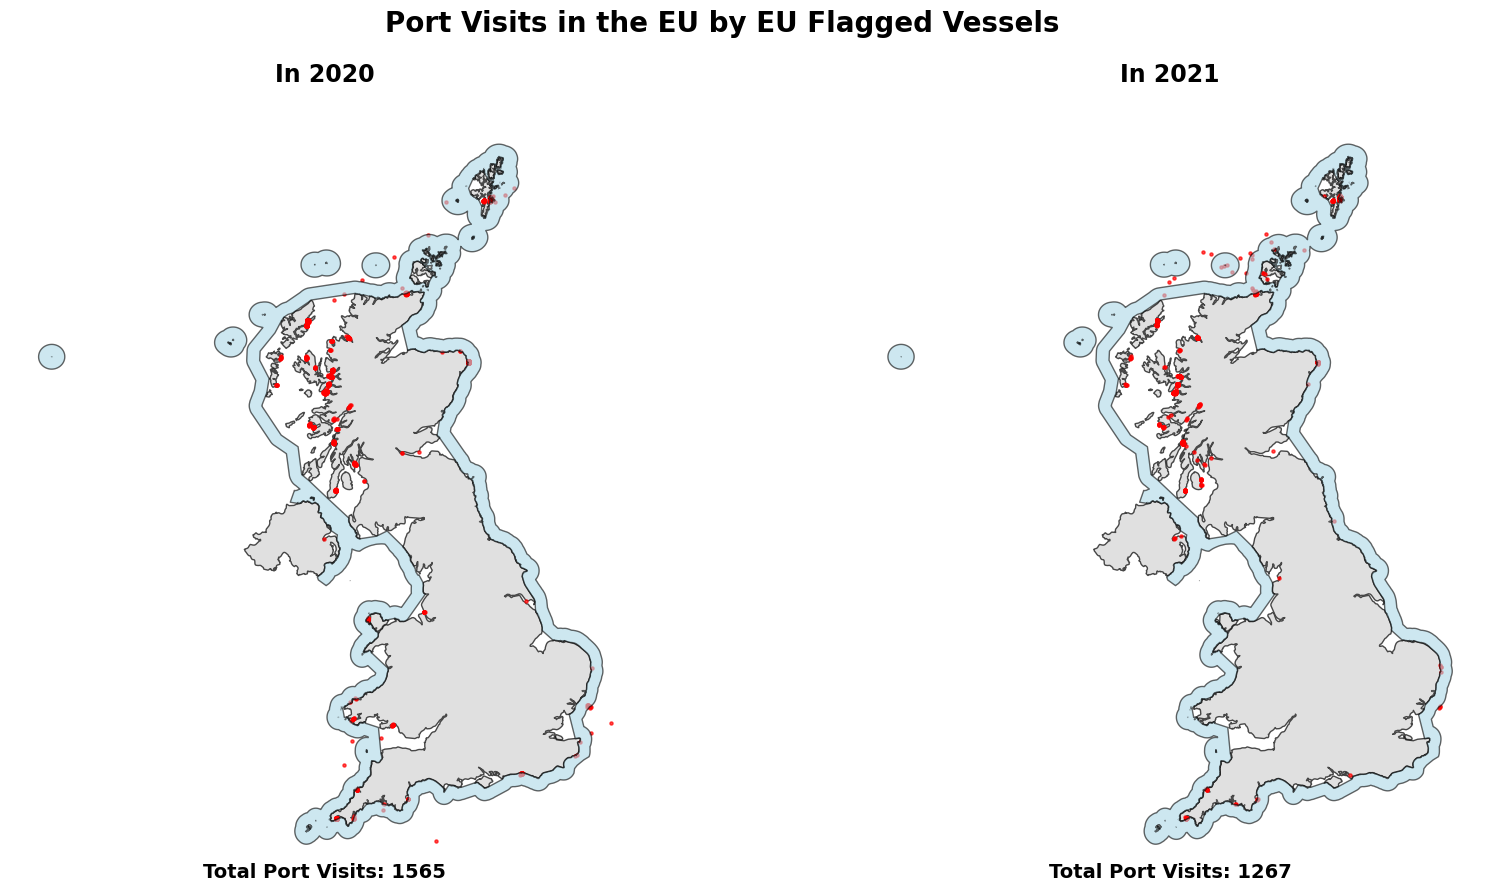

In [39]:
# Plot the EU map and the port_visits events
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, year in enumerate([2020, 2021]):
    uk.plot(ax=ax[i], color='lightgrey', edgecolor='black', alpha=0.7)
    gdf[(gdf['year_start'] == year) & (gdf['flag'] != 'GBR')].plot(ax=ax[i], color='red', markersize=5, alpha=0.7, label='Port Visits')
    uk_millas.plot(ax=ax[i], color='lightblue', edgecolor='black', alpha=0.6, label='12 miles zone')
    
    ax[i].set_title(f"In {year}", fontsize=17, fontweight='bold', pad=20)
    ax[i].set_axis_off()
    ax[i].text(0.5, 0.01, f"Total Port Visits: {gdf[(gdf['year_start'] == year) & (gdf['flag'] != 'GBR')].shape[0]}", 
               horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=14, fontweight='bold')
plt.suptitle("Port Visits in the EU by EU Flagged Vessels", fontsize=20, fontweight='bold')
plt.savefig(r"C:\Users\alezi\OneDrive\Escritorio\Master_Thesis\figures\fishing_events_by_euflag.png")
plt.show()